<a href="https://colab.research.google.com/github/chaiminwoo0223/Computer-Vision/blob/main/Class9/program02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10을 분류하는 비전 트랜스포머: 영상 확대와 데이터 증강으로 성능 향상하기

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

from keras import layers
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
n_class = 10
img_siz = (32, 32, 3)
img_expanded_siz = (72, 72, 3)
patch_siz = 6
p2 = (img_expanded_siz[0]//patch_siz) ** 2
d_model = 64
h = 8
N = 6

170498071/170498071 [==============================] - 13s 0us/step


In [3]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.p_siz = patch_size

    def call(self, img):
        batch_size = tf.shape(img)[0]
        patches = tf.image.extract_patches(images=img, sizes=[1, self.p_siz, self.p_siz, 1], strides=[1, self.p_siz, self.p_siz, 1], rates=[1,1,1,1], padding='VALID')
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, p2, d_model):
        super(PatchEncoder, self).__init__()
        self.p2 = p2
        self.projection = layers.Dense(units = d_model)
        self.position_embedding = layers.Embedding(input_dim=p2, output_dim=d_model)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.p2, delta=1)
        encoded = self.projection(patch)+self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    input = layers.Input(shape=(img_siz))
    nor = layers.Normalization()(input)
    exp = layers.Resizing(img_expanded_siz[0], img_expanded_siz[1])(nor)
    x = layers.RandomFlip('horizontal')(exp)
    x = layers.RandomRotation(factor=0.02)(x)
    x = layers.RandomZoom(height_factor=0.2, width_factor=0.2)(x)
    patches=Patches(patch_siz)(x)
    x = PatchEncoder(p2, d_model)(patches)

    for _ in range(N):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        x2 = layers.MultiHeadAttention(num_heads=h, key_dim=d_model//h, dropout=0.1)(x1,x1)
        x3 = layers.Add()([x2,x])
        x4 = layers.LayerNormalization(epsilon=1e-6)(x3)
        x5 = layers.Dense(d_model*2, activation=tf.nn.gelu)(x4)
        x6 = layers.Dropout(0.1)(x5)
        x7 = layers.Dense(d_model, activation=tf.nn.gelu)(x6)
        x8 = layers.Dropout(0.1)(x7)
        x = layers.Add()([x8,x3])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(2048, activation=tf.nn.gelu)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation=tf.nn.gelu)(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(n_class, activation='softmax')(x)
    model = keras.Model(inputs=input, outputs=output)
    return model

In [4]:
model = create_vit_classifier()
model.layers[1].adapt(x_train)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
hist = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test), verbose=1)
res = model.evaluate(x_test, y_test, verbose=0)
print('정확률 =', res[1]*100)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


391/391 [==============================] - 89s 169ms/step - loss: 1.9096 - accuracy: 0.3479 - val_loss: 1.4303 - val_accuracy: 0.4949
Epoch 2/50
391/391 [==============================] - 65s 165ms/step - loss: 1.4814 - accuracy: 0.4725 - val_loss: 1.2467 - val_accuracy: 0.5394
Epoch 3/50
391/391 [==============================] - 63s 161ms/step - loss: 1.3410 - accuracy: 0.5244 - val_loss: 1.1772 - val_accuracy: 0.5763
Epoch 4/50
391/391 [==============================] - 64s 165ms/step - loss: 1.2613 - accuracy: 0.5554 - val_loss: 1.0209 - val_accuracy: 0.6399
Epoch 5/50
391/391 [==============================] - 65s 165ms/step - loss: 1.1859 - accuracy: 0.5844 - val_loss: 0.9733 - val_accuracy: 0.6571
Epoch 6/50
391/391 [==============================] - 64s 165ms/step - loss: 1.1223 - accuracy: 0.6075 - val_loss: 0.9354 - val_accuracy: 0.6792
Epoch 7/50
391/391 [==============================] - 64s 165ms/step - loss: 1.0601 - accuracy: 0.6306 - val_loss: 0.8634 - val_accuracy: 0.7

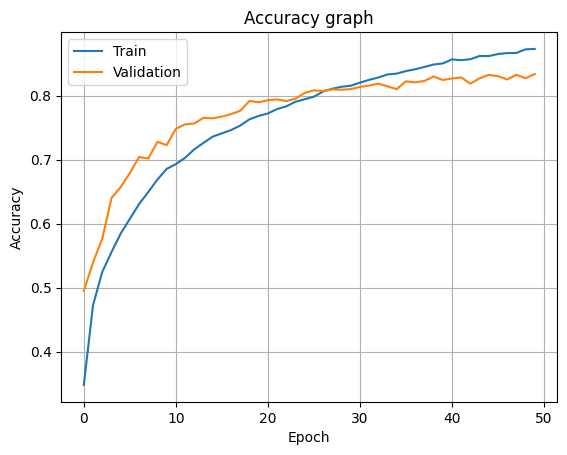

In [5]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy graph')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()
plt.show()

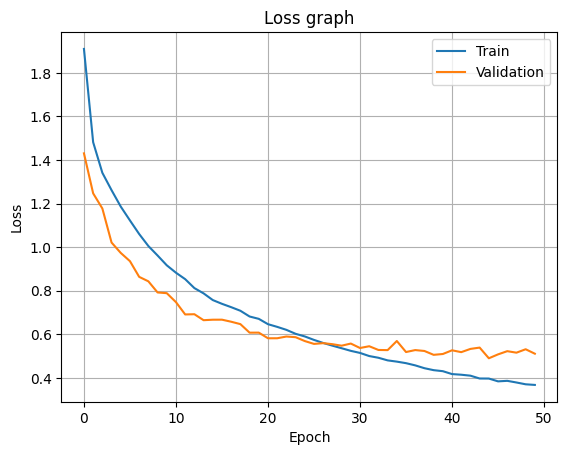

In [6]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.grid()
plt.show()